# pybeach

### A Python package for locating the dune toe on cross-shore beach profile transects.

### Table of Contents

This notebook demonstrates a few key elements of pybeach, including:
1. [Creating a custom classifier](#1)
2. [Predicting dune toes](#2)
3. [Example plots and results](#3)

### Setup

Read the __*pybeach*__ docs [here!](https://pybeach.readthedocs.io/en/latest/).

To run this notebook, pybeach should be installed. I recommend creating a new virtual environment and then running:

`pip install pybeach`

Depending on your setup, you may also need to install `jupyter` to run this notebook within the virtual environment, and if you want to generate plots in this notebook, you'll need `matplotlib`:

`pip install jupyter`

`pip install matplotlib`

### Imports

In [9]:
import os
import csv
import pickle
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pybeach.beach import Profile
from pybeach.support import data_support as ds
from pybeach.support import classifier_support as cs
%matplotlib inline

### Load test data

In [64]:
# Load some test data for a profile
#with open('NCB_profiles_test_2.csv') as f:
    #data = pd.read_csv(f, header = 0)
  
with open('NCB_profiles_test_5.csv') as t:
    data2 = pd.read_csv(t, header = 0)
data2


,X,Z1,Z2,Z3,Z4,Z5,Z6,Z7,Z8,Z9,toe
0,0.0000,4.315,3.517,2.271,3.156,1.851,2.454,1.679,2.542,2.887,442.0
1,0.0982,4.326,3.505,2.272,3.136,1.861,2.466,1.694,2.556,2.894,589.0
2,0.1965,4.336,3.494,2.274,3.116,1.871,2.479,1.709,2.571,2.902,433.0
3,0.2947,4.345,3.482,2.275,3.096,1.880,2.492,1.724,2.587,2.911,444.0
4,0.3929,4.352,3.472,2.275,3.076,1.890,2.505,1.740,2.601,2.921,800.0
...,...,...,...,...,...,...,...,...,...,...,...
1020,100.9000,0.090,NaN,NaN,NaN,1.294,1.296,1.632,NaN,1.572,NaN
1021,101.0000,0.088,NaN,NaN,NaN,1.286,1.294,1.633,NaN,1.566,NaN
1022,101.1000,0.086,NaN,NaN,NaN,1.278,1.291,1.633,NaN,1.560,NaN
1023,101.2000,0.084,NaN,NaN,NaN,1.269,1.289,1.632,NaN,1.553,NaN


In [96]:
#Create a larger array
x = np.array(data2['X'])
z1 = np.array(data2['Z1'])
z2 = np.array(data2['Z2'])
z3 = np.array(data2['Z3'])
z4 = np.array(data2['Z4'])
z5 = np.array(data2['Z5'])
z6 = np.array(data2['Z6'])
z7 = np.array(data2['Z7'])
z8 = np.array(data2['Z8'])
z9 = np.array(data2['Z9'])
z = np.array(data2['Z1'],data2['Z2'])
#toe = np.array(data2['toe'])
#z = np.stack[(z1,z2,z3,z4,z5,z6,z7,z8,z9)]

print(len(z))
type(z)
z

1025


array([4.315, 4.326, 4.336, ..., 0.086, 0.084, 0.081])

In [93]:
with open('test_profiles.pkl', 'rb') as p:
    pkl = pickle.load(p)
print('length of x is ' + str(len(pkl['x'])) + ' and length of z is ' + str(len(pkl['z'])) + ' and the number of dune toes is ' + str(len(pkl['toe'])))
pkl


length of x is 361 and length of z is 200 and the number of dune toes is 200


{'x': array([  0. ,   2.5,   5. ,   7.5,  10. ,  12.5,  15. ,  17.5,  20. ,
         22.5,  25. ,  27.5,  30. ,  32.5,  35. ,  37.5,  40. ,  42.5,
         45. ,  47.5,  50. ,  52.5,  55. ,  57.5,  60. ,  62.5,  65. ,
         67.5,  70. ,  72.5,  75. ,  77.5,  80. ,  82.5,  85. ,  87.5,
         90. ,  92.5,  95. ,  97.5, 100. , 102.5, 105. , 107.5, 110. ,
        112.5, 115. , 117.5, 120. , 122.5, 125. , 127.5, 130. , 132.5,
        135. , 137.5, 140. , 142.5, 145. , 147.5, 150. , 152.5, 155. ,
        157.5, 160. , 162.5, 165. , 167.5, 170. , 172.5, 175. , 177.5,
        180. , 182.5, 185. , 187.5, 190. , 192.5, 195. , 197.5, 200. ,
        202.5, 205. , 207.5, 210. , 212.5, 215. , 217.5, 220. , 222.5,
        225. , 227.5, 230. , 232.5, 235. , 237.5, 240. , 242.5, 245. ,
        247.5, 250. , 252.5, 255. , 257.5, 260. , 262.5, 265. , 267.5,
        270. , 272.5, 275. , 277.5, 280. , 282.5, 285. , 287.5, 290. ,
        292.5, 295. , 297.5, 300. , 302.5, 305. , 307.5, 310. , 312.5,
 

In [55]:
#Get the x and z columns into an array
#x = np.array(data['X'])
#z = np.array(data['Z'])


In [69]:
#Make a quick plot
#plt.plot(x,z)

# 1. Creating a custom classifier <a name="1"></a>

In [81]:
# Create classifier
#clf = cs.create_classifier(x, z, toe, window=40, min_buffer=40, max_buffer=200)

# Uncomment to save classifier to package directory
# import pybeach
# path = os.path.dirname(pybeach.__file__) + '/classifiers/'
# with open(path) as f:
#     joblib.dump(clf, f, protocol=pickle.HIGHEST_PROTOCOL)

# 2. Predicting dune toes <a name="2"></a>

In [82]:
# Instantiate Profile class
p = Profile(x, z)
# Make predictions of dune toe
toe_ml, prob_ml = p.predict_dunetoe_ml('barrier_island_clf', dune_crest='rr', window_size=101, threshold=0.97)
toe_mc = p.predict_dunetoe_mc(dune_crest='rr', window_size=101, threshold=0.97)
toe_rr = p.predict_dunetoe_rr(dune_crest='rr', window_size=101, threshold=0.97, toe_threshold=0.2, verbose=False)
toe_pd = p.predict_dunetoe_pd(dune_crest='rr', window_size=101, threshold=0.97)
# Predict dune crest
crest = p.predict_dunecrest()
# Predict shoreline
shoreline = p.predict_shoreline()


AssertionError: z should be of type ndarray.

# 3. Example plots and results <a name="3"></a>

In [31]:
# Plotting Paramaters
params = {'legend.fontsize': 12,
           'axes.labelsize': 14,
           'axes.labelweight': 'bold',
           'axes.titlesize': 14,
           'axes.titleweight': 'bold',
           'xtick.labelsize': 14,
           'ytick.labelsize': 14,
           'mathtext.default':'regular'}
plt.rcParams.update(params)

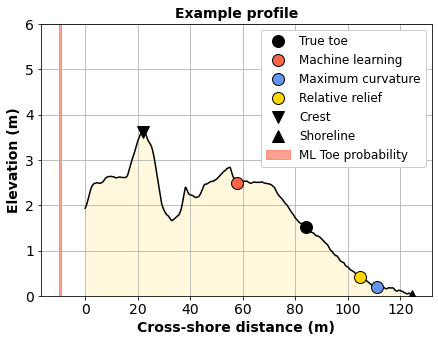

In [39]:
# Specify profile to plot
n = 0

# Figure metadata
fig, axes = plt.subplots(1, 1, figsize=(7, 5))
[toe_ml[n], toe_mc[n], toe_rr[n], toe_pd[n]] #toes = [toe_ml, toe_mc, toe_rr, toe_pd] 
labels = ['True toe', 'Machine learning', 'Maximum curvature', 'Relative relief', 'Perpendicular distance']
colors = ['k', 'tomato', 'cornflowerblue', 'gold', 'limegreen']

# Generate figure
axes.plot(x, z, '-k') #axes.plot(x, z[n], '-k')
axes.fill_between([70, 100], [0, 0], y2=-1, color='lightskyblue', alpha=0.5)
axes.fill_between(x, z[n], y2=-1, color='cornsilk', alpha=1) #axes.fill_between(x, z, y2=-1, color='cornsilk', alpha=1) 
axes.axvspan(-10, -9, color='tomato', alpha = 0.6, label='ML Toe probability') # legend placeholder

for i, itoe in enumerate(toes): 
    axes.plot(x[itoe], z[n, itoe], #axes.plot(x[itoe], z[itoe], 
              'o', color=colors[i], ms=12, mec='k', label=labels[i])
axes.plot(x[crest[n]], z[n, crest[n]], 'v', color='k', ms=12, mec='k', label='Crest') #axes.plot(x[crest], z[crest], 'v', color='k', ms=12, mec='k', label='Crest') #
axes.plot(x[shoreline[n]], z[n, shoreline[n]], '^', color='k', ms=12, mec='k', label='Shoreline') #axes.plot(x[shoreline], z[shoreline], '^', color='k', ms=12, mec='k', label='Shoreline') #
#axes.set_xlim(200, 400)
axes.set_ylim(0, 6)
axes.set_title('Example profile')
axes.set_xlabel('Cross-shore distance (m)')
axes.set_ylabel('Elevation (m)')
axes.grid()
axes.legend(framealpha=1)

# Plot dune toe ML probability
# axes2 = axes.twinx() 
# axes2.fill_between(x, prob_ml, color='tomato', alpha=0.5) #axes2.fill_between(x, prob_ml[n], color='tomato', alpha=0.5)
# axes2.set_ylim(0, 6)
# axes2.set_yticks([0, 1])
# axes2.tick_params(axis='y', labelcolor='tomato')
# axes2.yaxis.set_label_coords(1.1, 0.1)
# axes2.set_ylabel('Toe probability', color='tomato', rotation=270);

NameError: name 'toe' is not defined

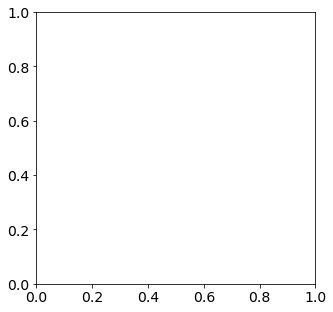

In [38]:
# Figure metadata
fig, axes = plt.subplots(1, 1, figsize=(5, 5))
colors = ['tomato', 'cornflowerblue', 'gold', 'limegreen']
labels = ['Machine\nLearning\n(MC)', 'Max.\nCurvature\n(MC)', 'Relative\nRelief\n(RR)', 'Perp.\nDistance\n(PD)']
# Generate figure
data = (toe - np.vstack((toe_ml, toe_mc, toe_rr, toe_pd))).T.astype("float64")
# data1[:,2] *= 0.7
bplot = axes.boxplot(data,
                     labels=labels,
                     patch_artist=True,
                     medianprops = dict(linewidth=2.5, color='k'))
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)
axes.set_ylabel('Prediction error (m)')
axes.set_xlabel('Method', labelpad=5)
axes.set_ylim(-40, 40)
axes.grid()
axes.set_title("Performance on test dataset")
plt.tight_layout()

In [8]:
df = pd.DataFrame({'MAE': [np.absolute(toe-toe_ml).mean(),
                           np.absolute(toe-toe_mc).mean(),
                           np.absolute(toe-toe_rr).mean(),
                           np.absolute(toe-toe_pd).mean()],
                   'RMSE': [np.sqrt(np.square(toe-toe_ml).mean()),
                            np.sqrt(np.square(toe-toe_mc).mean()),
                            np.sqrt(np.square(toe-toe_rr).mean()),
                            np.sqrt(np.square(toe-toe_pd).mean())],
                   'R2': [1 - (np.square(toe-toe_ml)).sum() / (np.square(toe-toe.mean())).sum(),
                          1 - (np.square(toe-toe_mc)).sum() / (np.square(toe-toe.mean())).sum(),
                          1 - (np.square(toe-toe_rr)).sum() / (np.square(toe-toe.mean())).sum(),
                          1 - (np.square(toe-toe_pd)).sum() / (np.square(toe-toe.mean())).sum()]},
                  index=['ML', 'MC', 'RR', 'PD']).round(2)
df

,MAE,RMSE,R2
ML,2.40,5.17,0.99
MC,7.59,10.57,0.96
RR,8.59,11.22,0.95
PD,5.18,8.22,0.98
